<a href="https://colab.research.google.com/github/hannahbanjo/AssociationOfDataScience/blob/main/webscraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping Workshop

## Install and import required libraries

In [1]:
# Install necessary libraries if not already installed
!pip install requests beautifulsoup4 textblob vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [13]:
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
import json
import time
# Download VADER lexicon
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Quote Scraper and Sentiment Analyzer



Let's start by scraping some quotes. Once we have our scraped quotes we will perform sentiment analysis.

### Step 1: Scrape Quotes from quotes.toscrape.com



In [3]:
def scrape_all_quotes():
    quotes_data = []
    url = 'http://quotes.toscrape.com/page/1/'

    while url:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        quote_elements = soup.select("div.quote")

        for q in quote_elements:
            text = q.find("span", class_="text").get_text(strip=True)
            author = q.find("small", class_="author").get_text(strip=True)
            tags = [tag.get_text(strip=True) for tag in q.select("div.tags a.tag")]

            quotes_data.append({
                "quote": text,
                "author": author,
                "tags": tags
            })

        # Pagination
        next_btn = soup.find("li", class_="next")
        if next_btn:
            next_page = next_btn.find("a")["href"]
            url = "http://quotes.toscrape.com" + next_page
        else:
            break

    return pd.DataFrame(quotes_data)

### Step 2: Analyze Sentiment with TextBlob and VADER

In [4]:
def add_sentiment_scores(df):
    sia = SentimentIntensityAnalyzer()
    df = df.copy()

    df['textblob_sentiment'] = df['quote'].apply(lambda text: TextBlob(text).sentiment.polarity)
    df['vader_sentiment'] = df['quote'].apply(lambda text: sia.polarity_scores(text)['compound'])

    return df

df_raw = scrape_all_quotes()
print(f"Scraped {len(df_raw)} quotes.")

# Step 2: Add sentiment analysis
df_quotes = add_sentiment_scores(df_raw)

textblob_scores = df_quotes['textblob_sentiment'].tolist()
vader_scores = df_quotes['vader_sentiment'].tolist()

df_quotes.head()

Scraped 100 quotes.


,quote,author,tags,textblob_sentiment,vader_sentiment
0,“The world as we have created it is a process ...,Albert Einstein,"[change, deep-thoughts, thinking, world]",0.000000,0.2500
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"[abilities, choices]",0.300000,0.4404
2,“There are only two ways to live your life. On...,Albert Einstein,"[inspirational, life, live, miracle, miracles]",0.003788,-0.4717
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"[aliteracy, books, classic, humor]",-0.050000,0.2964
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"[be-yourself, inspirational]",-0.277778,0.2516


### Step 3: Plot Sentiment Distributions

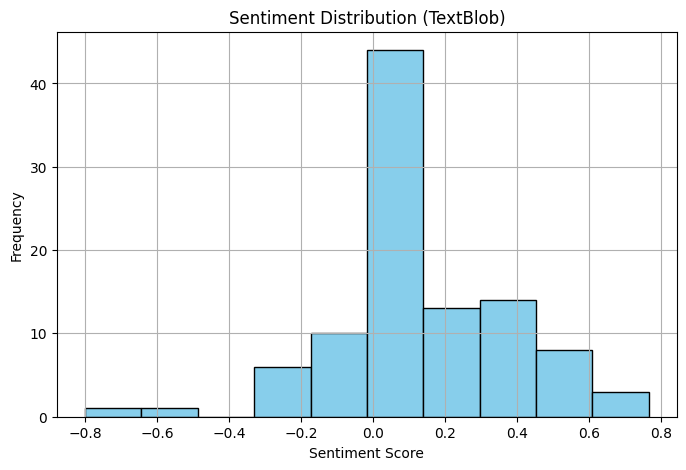

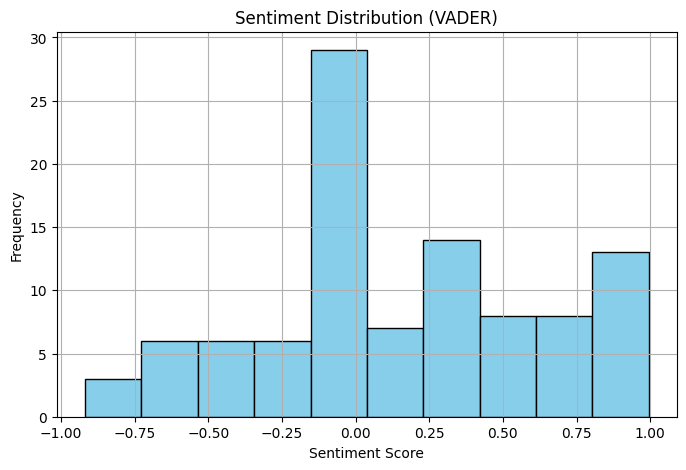

In [5]:
def plot_sentiment(sentiments, title):
    plt.figure(figsize=(8, 5))
    plt.hist(sentiments, bins=10, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_sentiment(textblob_scores, "Sentiment Distribution (TextBlob)")
plot_sentiment(vader_scores, "Sentiment Distribution (VADER)")


### Step 4: Interactive Explorer

In [22]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# STEP 1: Scrape quotes (without sentiment)
def get_quotes():
    quotes_data = []
    url = 'http://quotes.toscrape.com'

    while url:
        res = requests.get(url)
        soup = BeautifulSoup(res.text, 'html.parser')
        quotes = soup.find_all('div', class_='quote')

        for quote in quotes:
            text = quote.find('span', class_='text').get_text()
            author = quote.find('small', class_='author').get_text()
            tags = [tag.get_text() for tag in quote.find_all('a', class_='tag')]

            quotes_data.append({
                'quote': text,
                'author': author,
                'tags': tags
            })

        # Check for next page
        next_btn = soup.find('li', class_='next')
        url = url + next_btn.a['href'] if next_btn else None

    return pd.DataFrame(quotes_data), quotes_data

# STEP 2: Add sentiment analysis to DataFrame
def add_sentiment_scores(df):
    df['textblob_sentiment'] = df['quote'].apply(lambda text: TextBlob(text).sentiment.polarity)
    df['vader_sentiment'] = df['quote'].apply(lambda text: sia.polarity_scores(text)['compound'])
    return df

# STEP 3: Load and process data
df, quotes_data = get_quotes()
df = add_sentiment_scores(df)

# STEP 4: Create widgets
tag_input = widgets.Text(description='Tag:')
sentiment_slider = widgets.FloatRangeSlider(
    value=[-1.0, 1.0],
    min=-1.0,
    max=1.0,
    step=0.1,
    description='TextBlob Sentiment:',
    continuous_update=False
)
output = widgets.Output()

# STEP 5: Update filtered quote table
def update_table(change=None):
    output.clear_output()
    tag = tag_input.value.lower().strip()
    sentiment_range = sentiment_slider.value

    # Filter by sentiment
    filtered = df[
        df['textblob_sentiment'].between(sentiment_range[0], sentiment_range[1])
    ]

    # Filter by tag
    if tag:
        filtered = filtered[
            filtered['tags'].apply(lambda tags: tag in [t.lower() for t in tags])
        ]

    # Display top 10 filtered results
    with output:
        display(filtered[['quote', 'author', 'tags', 'textblob_sentiment', 'vader_sentiment']].head(10))

# Link widgets to update function
tag_input.observe(update_table, names='value')
sentiment_slider.observe(update_table, names='value')

# STEP 6: Display UI
display(tag_input, sentiment_slider, output)
update_table()


Text(value='', description='Tag:')

FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='TextBlob Sentiment:', max=1.0, min=-…

Output()

### Step 6: Plot the tag frequency

<ipython-input-23-6308780adeb1>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tag_df.head(10), x='Count', y='Tag', palette='viridis')


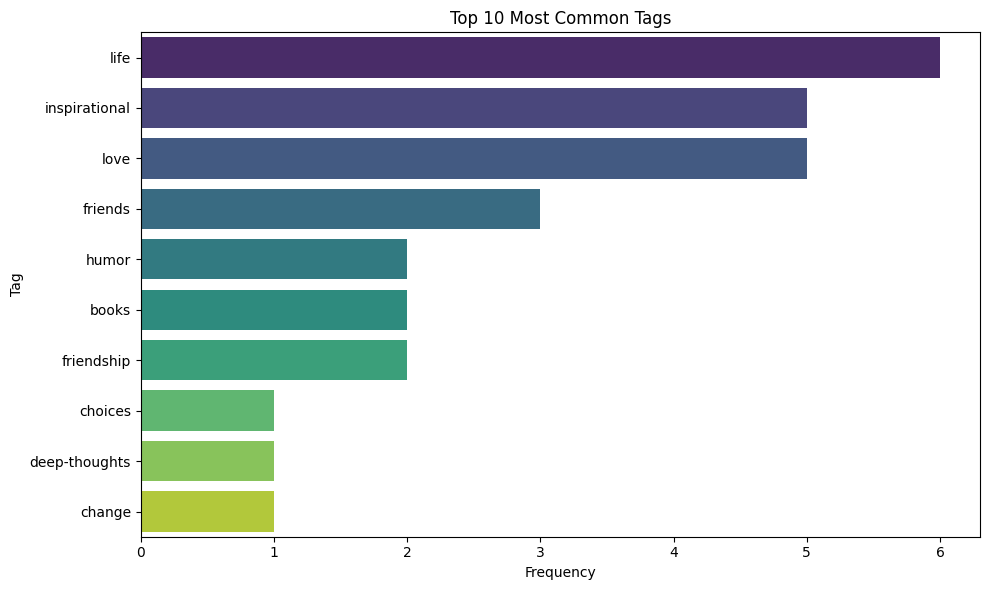

In [23]:
# Flatten tag lists and count occurrences
all_tags = [tag.lower() for quote in quotes_data for tag in quote['tags']]
tag_counts = Counter(all_tags)

# Convert to DataFrame for plotting
tag_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count']).sort_values(by='Count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=tag_df.head(10), x='Count', y='Tag', palette='viridis')
plt.title("Top 10 Most Common Tags")
plt.xlabel("Frequency")
plt.ylabel("Tag")

# Set integer ticks only
max_count = tag_df['Count'].max()
plt.xticks(ticks=range(0, int(max_count) + 1))

plt.tight_layout()
plt.show()


In [8]:
# Save the current filtered DataFrame to CSV
df.to_csv('quotes.csv', index=False)


## Craigslist Housing Data Scraper

### Step 1: Scrape Multiple Pages

In [15]:
url = "https://charlotte.craigslist.org/search/apa"
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

def scrape_craigslist_multiple_pages(base_url, pages=3, delay=1):
    all_listings = []

    for page in range(pages):
        offset = page * 120
        url = f"{base_url}?s={offset}"
        print(f"Scraping page {page + 1}: {url}")

        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')

        script_tag = soup.find('script', id='ld_searchpage_results', type='application/ld+json')
        if not script_tag:
            print(f"No listing data found on page {page + 1}")
            continue

        raw_json = json.loads(script_tag.string)
        for element in raw_json.get('itemListElement', []):
            item = element.get('item', {})
            address = item.get('address', {})
            all_listings.append({
                'name': item.get('name'),
                'neighborhood': address.get('addressLocality'),
                'region': address.get('addressRegion'),
                'bathrooms': item.get('numberOfBathroomsTotal'),
            })

        time.sleep(delay)  # Be polite to Craigslist

    return pd.DataFrame(all_listings)

# Example: scrape 5 pages from NYC housing
df = scrape_craigslist_multiple_pages("https://charlotte.craigslist.org/search/apa", pages=5)
display(df.head())
print(f"Total listings scraped: {len(df)}")


Scraping page 1: https://charlotte.craigslist.org/search/apa?s=0
Scraping page 2: https://charlotte.craigslist.org/search/apa?s=120
Scraping page 3: https://charlotte.craigslist.org/search/apa?s=240
Scraping page 4: https://charlotte.craigslist.org/search/apa?s=360
Scraping page 5: https://charlotte.craigslist.org/search/apa?s=480


,name,neighborhood,region,bathrooms
0,"2BD 2BA, Updated Bathrooms, Located in Charlotte",Charlotte,NC,2
1,"Comfortable 1 bed, 1 bath, prime location!",Charlotte,NC,1
2,"Everything you want and MORE! 641 sq ft 1 bed,...",Fort Mill,SC,1
3,"A New Day, A Fresh Start: Your Ideal Home Awaits!",Concord,NC,1
4,"Amazing 1 Bed, 1 Bath with public transit acce...",Charlotte,NC,1


Total listings scraped: 1765


### Step 2: Clean and Preprocess Data

In [16]:
# Remove rows with missing important columns
df = df.dropna(subset=['name', 'neighborhood'])

# Convert numerical columns
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

# Remove duplicates if any
df = df.drop_duplicates()

# Display cleaned data
display(df.head())


,name,neighborhood,region,bathrooms
0,"2BD 2BA, Updated Bathrooms, Located in Charlotte",Charlotte,NC,2
1,"Comfortable 1 bed, 1 bath, prime location!",Charlotte,NC,1
2,"Everything you want and MORE! 641 sq ft 1 bed,...",Fort Mill,SC,1
3,"A New Day, A Fresh Start: Your Ideal Home Awaits!",Concord,NC,1
4,"Amazing 1 Bed, 1 Bath with public transit acce...",Charlotte,NC,1


### Step 3: Summary Statistics

In [17]:
# Basic summary stats
print("Summary Statistics for Bathrooms:")
print(df['bathrooms'].describe())

# Most common neighborhoods
print("\nTop 10 neighborhoods:")
print(df['neighborhood'].value_counts().head(10))


Summary Statistics for Bathrooms:
count    322.000000
mean       1.487578
std        0.553804
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: bathrooms, dtype: float64

Top 10 neighborhoods:
neighborhood
Charlotte      163
Concord         42
Gastonia        26
Mooresville     19
Rock Hill       17
Fort Mill       16
Statesville     12
Kannapolis       6
Matthews         6
Salisbury        6
Name: count, dtype: int64


### Step 4: Visualize Bathroom Distribution

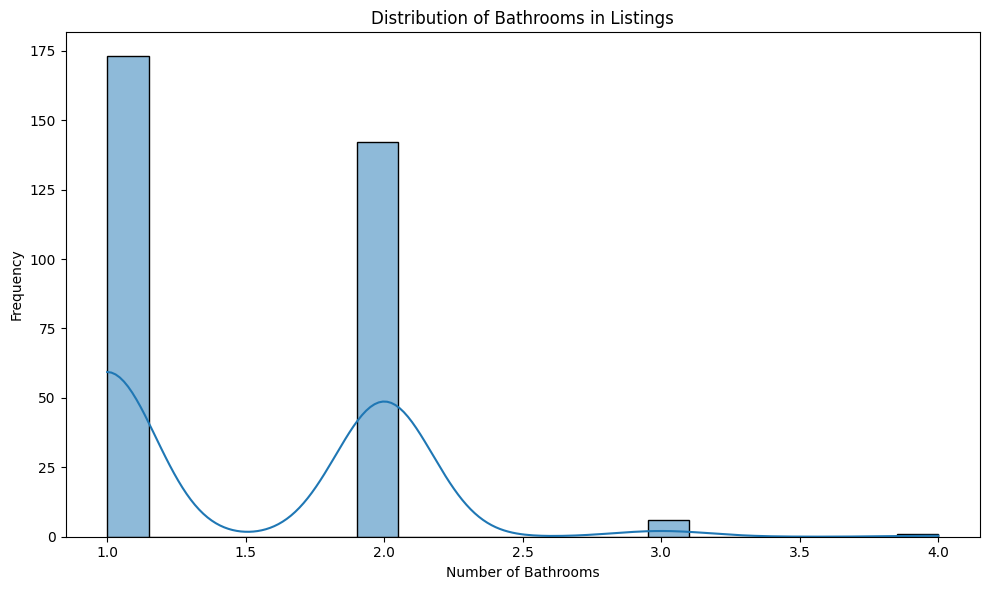

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['bathrooms'], kde=True, bins=20)
plt.title('Distribution of Bathrooms in Listings')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### Step 5: Interactive Explorer

In [19]:
# Dropdown for neighborhood selection
neighborhoods = sorted(df['neighborhood'].dropna().unique())
neighborhood_dropdown = widgets.Dropdown(
    options=["All"] + neighborhoods,
    value="All",
    description='Neighborhood:',
    layout=widgets.Layout(width='50%')
)

# Slider for bathroom range
bathroom_slider = widgets.FloatRangeSlider(
    value=[0.0, df['bathrooms'].max()],
    min=0.0,
    max=df['bathrooms'].max(),
    step=0.5,
    description='Bathrooms:',
    continuous_update=False,
    layout=widgets.Layout(width='60%')
)

# Output area for displaying filtered DataFrame
output = widgets.Output()

# Filter function
def update_display(change=None):
    with output:
        clear_output()
        filtered_df = df.copy()

        # Filter by neighborhood
        if neighborhood_dropdown.value != "All":
            filtered_df = filtered_df[filtered_df['neighborhood'] == neighborhood_dropdown.value]

        # Filter by bathroom count
        min_bath, max_bath = bathroom_slider.value
        filtered_df = filtered_df[filtered_df['bathrooms'].between(min_bath, max_bath)]

        # Display first 10 results
        display(filtered_df[['name', 'neighborhood', 'bathrooms']].head(10))

# Bind change events
neighborhood_dropdown.observe(update_display, names='value')
bathroom_slider.observe(update_display, names='value')

# Initial display
display(neighborhood_dropdown, bathroom_slider, output)
update_display()

Dropdown(description='Neighborhood:', layout=Layout(width='50%'), options=('All', 'Belmont', 'Bessemer City', …

FloatRangeSlider(value=(0.0, 4.0), continuous_update=False, description='Bathrooms:', layout=Layout(width='60%…

Output()

In [20]:
# Save the current filtered DataFrame to CSV
df.to_csv('craigslist.csv', index=False)
